# DunnHumby: The Complete Journey
--- 
    Nathaniel Poland
    Feb 2024
## Introduction

Welcome to my Capstone Project! 

In this project we will explore **The Complete Journey**; a dataset available on Kaggle and generated by the Dunnhumby company with the assistance of Raj Venkatesan. This dataset was suggested to me by Myles Harrison, my instructor at the BrainStation Data Science and Analytics bootcamp which I completed over the Summer 2021.

I'm deeply grateful for the recommendation, and wrestling with this data I have learned and practiced so many things that have served me well as I continue on my own 'complete journey' into data analytics and machine learning.
# The Problem Space

This dataset is purportedly from a grocery chain firm. The data comprises **8 .csv files**, and resembles a **relational database**.


Let's make a sqlite database and import our source tables. From there, we'll explore the critical tables and creating staging tables. 

In [1]:
import sqlite3
import pandas as pd
from utilities import query, read_table, drop_table, list_all_tables
import glob
glob.glob('data/*.csv')
#sqlite3.connect('dunnhumby.db')

# see the initial data source conversions in 'create_source_tables.py'

['data\\campaign_desc.csv',
 'data\\campaign_table.csv',
 'data\\causal_data.csv',
 'data\\coupon.csv',
 'data\\coupon_redempt.csv',
 'data\\hh_demographic.csv',
 'data\\product.csv',
 'data\\transaction_data.csv']

In [2]:
list_all_tables()

['src_product',
 'src_transaction_data',
 'src_hh_demographic',
 'stg_transaction_data']

# Transactions EDA

In [4]:
transactions = read_table('stg_transaction_data')

# how much our sales is dependent on the top 100 stores and top 25% of purchasing customers?
transactions.shape # 2.4 million rows left
top_spending_customers = transactions.groupby('household_key')['sales_value'].sum().sort_values(ascending=False)[:625].index
top_100_stores= transactions.groupby('store_id')['sales_value'].sum().sort_values(ascending=False)[:100].index

transactions[transactions['household_key'].isin(top_spending_customers)] # top spenders account for 1.41 million rows
transactions[transactions['store_id'].isin(top_100_stores)] # almost all of the purchases are from the top 100 stores. 2.3 million rows. 
transactions[transactions['household_key'].isin(top_spending_customers) & transactions['store_id'].isin(top_100_stores)] # we would lose ~50k rows from our top spenders by excluding stores. 


# how many different stores do each of our customers purchase at?
hh_store_map = transactions[transactions['household_key'].isin(top_spending_customers)][['household_key', 'store_id']].drop_duplicates()
low_spend_hh_store_map = transactions[~transactions['household_key'].isin(top_spending_customers)][['household_key', 'store_id']].drop_duplicates()


#the average number of purchases per capita of each group?
transactions[transactions['household_key'].isin(low_spend_hh_store_map['household_key'])]['basket_id'].nunique()/low_spend_hh_store_map['household_key'].nunique() # 66 purchases/household for the lower-spenders
transactions[transactions['household_key'].isin(hh_store_map['household_key'])]['basket_id'].nunique()/hh_store_map['household_key'].nunique() # 214 purchases per household for the highier-spend group

<Axes: xlabel='date'>

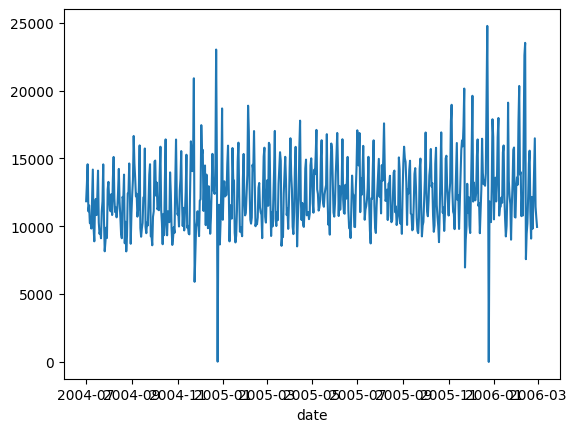

In [108]:
transactions['date'] = pd.to_datetime(transactions['datetime']).dt.date
transactions.groupby('date')['sales_value'].sum().plot()